<a href="https://colab.research.google.com/github/MinhQuangQu/test/blob/main/FINAL_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('Cleaned data.csv', encoding= 'latin1')

In [ ]:
from datetime import datetime

# Đảm bảo InvoiceDate là kiểu datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
latest_day = df['InvoiceDate'].max() + pd.Timedelta(days= 1)

dfRecentOrder = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
dfRecentOrder.columns = ['CustomerID', 'RecentOrderDate']

df = pd.merge(df, dfRecentOrder, on='CustomerID')

df['Recency'] = (latest_day - df['RecentOrderDate']).dt.days


In [ ]:
dfFrequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
dfFrequency.columns = ['CustomerID', 'Frequency']

df = pd.merge(df, dfFrequency, on='CustomerID')


In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
dfMonetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
dfMonetary.columns = ['CustomerID', 'Monetary']
df = pd.merge(df, dfMonetary, on='CustomerID')


In [ ]:
rfm = df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
rfm.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace= True)

<ipython-input-9-419f4e4f9f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm.drop_duplicates(subset = 'CustomerID', keep = 'first', inplace= True)


In [ ]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,92.518322,4.271261,2045.278187
std,1721.889758,100.009747,7.703916,8974.145981
min,12346.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,1.000000,306.290000
50%,15299.000000,51.000000,2.000000,668.430000
75%,16778.500000,142.000000,5.000000,1653.245000
max,18287.000000,374.000000,210.000000,280206.020000


In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

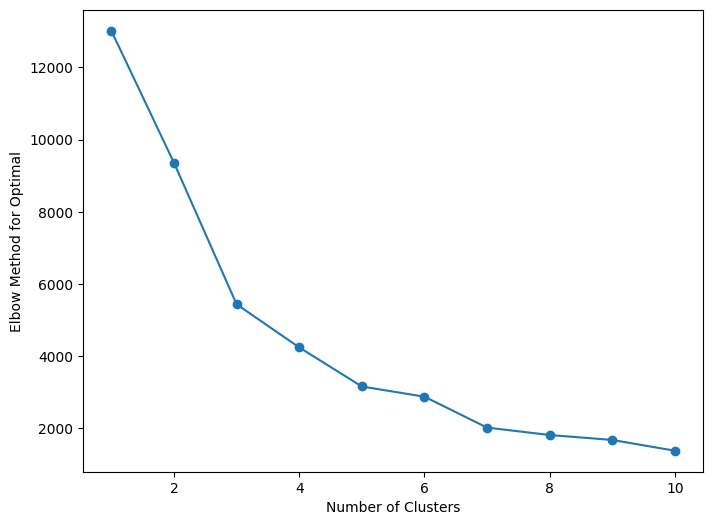

In [ ]:
wcss = []
k_range =  range(1,11)
for k in k_range:
  kmeans = KMeans(n_clusters = k, random_state= 42)
  kmeans.fit(rfm_scaled)
  wcss.append(kmeans.inertia_)

plt.figure(figsize =(8,6))
plt.plot(k_range, wcss, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Elbow Method for Optimal')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


<ipython-input-15-07f4bf79d334>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [ ]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster']

In [ ]:
# Xem số lượng khách hàng trong mỗi nhóm
print(rfm['Cluster'].value_counts())

# Trung bình RFM của từng nhóm
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())


Cluster
1    3228
0    1082
2      25
3       4
Name: count, dtype: int64
            Recency  Frequency       Monetary
Cluster                                      
0        247.106285   1.582255     629.540685
1         41.479864   4.633209    1828.778071
2          6.360000  67.320000   55527.712400
3          3.000000  45.500000  225452.652500


In [ ]:
rfm.to_csv('rfm.csv', index= False)

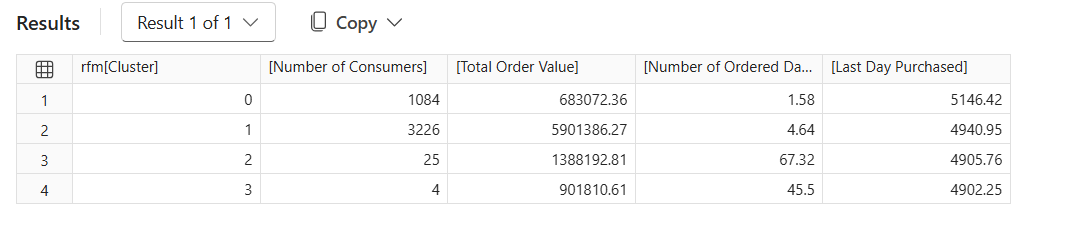